# Notebook 17: Energy-based Generative Models for MNIST


## Learning Goal
The goal of this notebook is to familiarize readers with various energy-based generative models including: Restricted Boltzmann Machines (RBMs) with Gaussian and Bernoulli units, Deep Boltzmann Machines (DBMs), as well as techniques for training these model including contrastive divergence (CD) and persistent constrastive divergence (PCD). We will also discuss how to generate new examples (commonly called fantasy particles in the ML literature). The notebook also introduces the [Paysage](https://github.com/drckf/paysage) package from [UnLearn.AI](https://unlearn.ai/) for quickly building and training these models..

## Overview
In this notebook, we study the MNIST dataset using generative models. 

Let us adopt a different perspective on the MNIST dataset. Generative models, as the name suggests, are useful to generate brand new data (images) by learning how to imitate the ones from a given data set. If you wish, they can be regarded as a kind of "creative ML". This is achieved by extracting/learning a set of features which represent the backbone of the entire data and are thus definitive for the particular dataset. These features are encoded in the weights of the model. 

Mathematically speaking, generative models are designed and trained to learn an approximation for the probability distribution that generated the data. Intuitively, this task is much more complex and sophisticated than the image recognition task. Therefore, we shall approach the problem in a number of steps of increasing complexity. For a more detailed discussion on the theory, we invite the reader to check out Secs. XV and XVI of the review.

Below, we analyze four different generative models: the Hopfield Model, a Restricted Boltzmann Machine (RBM), a regularized RMB with sparse weights, and a Deep Boltzmann Machine (DBM). In all these cases, we first set up and train the models. After that, we compare the results. Last, we open up the black box of each model and visualise a set of features it learned. 

## Setting up Paysage

In this notebook, we use an open-source `python` package for energy-based models, called [paysage](https://github.com/drckf/paysage). Paysage requires `python>3.5`; we recommend using the package with an [Anaconda](https://www.continuum.io/downloads) environment.

To install paysage: 

* clone or download the [github repo](https://github.com/drckf/paysage)
* activate an Anaconda3 environment
* navigate to the directory which contains the paysage files
* and execute
```
pip install .
```

Documentation for paysage is available under [https://github.com/drckf/paysage/tree/master/docs](https://github.com/drckf/paysage/tree/master/docs).

By default, computations in paysage are performed using `numpy`/`numexpr`/`numba` on the CPU. If you have installed [PyTorch](https://pytorch.org), then you can switch to the `pytorch` backend by changing the setting in `paysage/backends/config.json` to `pytorch`. 

Let us set up the required packages for this notebook by importing paysage.

In [18]:
from __future__ import print_function, division
import os
import paysage
import numpy as np
import pandas as pd

# for Boltzmann machines
from paysage import preprocess as pre
from paysage.layers import BernoulliLayer, GaussianLayer
from paysage.models import BoltzmannMachine
from paysage import batch
from paysage import fit
from paysage import optimizers
from paysage import samplers
from paysage import backends as be
from paysage import schedules
from paysage import penalties as pen

# fix random seed to ensure deterministic behavior
np.random.seed(137)
be.set_seed(137) 

## Obtaining the MNIST dataset

As we mentioned in the introduction, we use the MNIST dataset of handwritten digits to study the Hopfield model and various variants of RBMs. 

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ nuances of the grey colour, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. There are $10$ categories in the problem, corresponding to the ten digits. In previous notebooks, we formulated a classification task for the MNIST dataset, and studied it using discriminative supervised learning: Logistic Regression and Deep Neural Networks. 


This dataset can be fetched using paysage from the web as an `HDF5` file. For this, you should

* navigate to the directory in which you cloned/downloaded paysage
* navigate further into the `/examples/mnist/` directory which contains the file `download_mnist.py`.
* from the terminal, run the command 
```
python3 /examples/mnist/download_mnist.py
```

This file contains keys `train/images`, `train/labels`, `test/images`, and `test/labels` and is compressed to about 15 Mb in size.

As our first step, we will set up the paths to the data and shuffle the dataset. The shuffled dataset will not be compressed (for faster reading during training) so it will be about 56 Mb in size.

_Why shuffle the data?_ - Training with stochastic gradient descent means we will be using small minibatches of data (maybe 50 examples) to compute the gradient at each step. If the data have an order, then the estimates for the gradients computed from the minibatches will be biased. Shuffling the data ensures that the gradient estimates are unbiased (though still noisy).

In [19]:
paysage_path = os.path.dirname(".")
mnist_path = os.path.join(paysage_path, "examples", "mnist", "mnist.h5")
shuffled_mnist_path = os.path.join(paysage_path, "examples", "mnist", "shuffled_mnist.h5")

print("path to mnist data:")
print(mnist_path)

if not os.path.exists(mnist_path):
    raise IOError("{} does not exist. run mnist/download_mnist.py to fetch from the web".format(mnist_path))
    
if not os.path.exists(shuffled_mnist_path):
    batch.DataShuffler(mnist_path, shuffled_mnist_path, complevel=0).shuffle()

path to mnist data:
examples/mnist/mnist.h5


### Processing the Data

Next, we create a `data` generator, which splits the data into a training and validation sets, and separates them into minibatches of size `batch_size`. Before we begin training, we set `data` into training mode. 

To monitor the progress of performance metrics during training, we define the variable `performance` which tells Paysage to measure the reconstruction error from the validation set. Possible metrics include the reconstruction error (used in this example) and metrics related to difference in energy of random samples and samples from the model (see [`metrics.md`](https://github.com/drckf/paysage/blob/master/docs/metrics.md) in Paysage documentation for a complete list).

In [20]:
##### set up minibatch data generator
# batch size
batch_size=100 
transform = pre.Transformation(pre.binarize_color)

# create data generator object with minibathces
samples = be.float_tensor(pd.read_hdf(shuffled_mnist_path, key='train/images').values)
data = batch.in_memory_batch(samples, batch_size, train_fraction=0.95, transform=transform)

# reset the data generator in training mode
data.reset_generator(mode='train') 

### Setting up a Hopfield Model

Having loaded and preprocessed the data, we now move on to construct a `hopfield` model. To do this, we use the `Model` class and with a visible `BernoulliLayer` and a hidden `GaussianLayer`. Note that the visible layer has the same size as the input data points, which is can be read off `data.ncols`. The number of hidden units is `num_hidden_units`. We also set the mean and variance of the Gaussian layer to zero and unity, respectively (the notation here is inspired by the terminology in Variational Auto Encoders).

We choose to train the model with the `Adam` optimizer. To ensure convergence, we attenuate the `learning_rate` hyperparameter according to a `PowerLawDecay` schedule: `learning_rate`$(t)$ =`initial`$/(1 +$ `coefficient`$\;\times\; t)$. It will prove convenient to define the function `Adam_optimizer()` for this purpose.

In [21]:
##### create hopfield model
# hidden units
num_hidden_units=200 

# set up the model
vis_layer = BernoulliLayer(data.ncols)
hid_layer = GaussianLayer(num_hidden_units)
hopfield = BoltzmannMachine([vis_layer, hid_layer])

# set mean and standard deviation of hidden layer to to 0 and 1, respectively
hopfield.layers[1].set_fixed_params(['loc', 'log_var'])

# set up an optimizer method (ADAM in this case)
def ADAM_optimizer(initial,coefficient):
	# define learning rate attenuation schedule
	learning_rate=schedules.PowerLawDecay(initial=initial,coefficient=coefficient)
	# return optimizer object
	return optimizers.ADAM(stepsize=learning_rate)

### Compiling and Training a Model in Paysage

Next, we have compile the model. First, we initialize a `model` using the `initialize` function attribute which accepts the `data` as a required argument. We choose the initialization routine `glorot`, see discussion in review. Second, we define an optimizer calling the function `Adam_optimizer()` defined above, and store the object under the name `opt`. To define a Monte Carlo `sampler`, we use the method `from_batch` of the `SequentialMC` class, parsing the `model` and the `data`. Last, we create an `SGD` object called `trainer` to train the model using Persistent Contrastive Divergence (`pcd`) with a fixed number of `monte_carlo_steps`. We can also `monitor` the reconstruction error during training. Last, we train the model in epochs (see variable `nim_epochs`), calling the `train()` method of `trainer`. These steps are universal for shallow generative `model`'s, and it is convenient to combine them in the function `train_model()`.

In [38]:
# define function to compile and train model
num_epochs=20 # training epochs
monte_carlo_steps=1 # number of MC sampling steps
def train_model(model,num_epochs,monte_carlo_steps):
        # make a simple guess for the initial parameters of the model
        model.initialize(data,method='glorot_normal')
        # set optimizer
        opt=ADAM_optimizer(1E-2,1.0)
        trainer = fit.SGD(model, data)
        trainer.train(opt, num_epochs, method=fit.pcd, mcsteps=monte_carlo_steps)
        trained_performance = trainer.monitor.memory[-1]
        return trained_performance['ReconstructionError']
# train hopfield model
train_model(hopfield,num_epochs,monte_carlo_steps)

Before training:
-ReconstructionError: 1.201182
-EnergyCoefficient: 0.135515
-HeatCapacity: 0.417739
-WeightSparsity: 0.333022
-WeightSquare: 1.600422
-KLDivergence: 0.188099
-ReverseKLDivergence: -0.035084

End of epoch 1: 
Time elapsed 6.904s
-ReconstructionError: 0.767796
-EnergyCoefficient: 0.222740
-HeatCapacity: 7.013842
-WeightSparsity: 0.281583
-WeightSquare: 2.578349
-KLDivergence: 0.067376
-ReverseKLDivergence: 0.125161

End of epoch 2: 
Time elapsed 6.979s
-ReconstructionError: 0.736764
-EnergyCoefficient: 0.284274
-HeatCapacity: 10.629928
-WeightSparsity: 0.280047
-WeightSquare: 2.835555
-KLDivergence: 0.077170
-ReverseKLDivergence: 0.192396

End of epoch 3: 
Time elapsed 7.003s
-ReconstructionError: 0.733963
-EnergyCoefficient: 0.307479
-HeatCapacity: 5.454783
-WeightSparsity: 0.277883
-WeightSquare: 2.929371
-KLDivergence: 0.077526
-ReverseKLDivergence: 0.228514

End of epoch 4: 
Time elapsed 7.021s
-ReconstructionError: 0.727311
-EnergyCoefficient: 0.346004
-HeatCapacity

0.6622103018718121

## More Generative Models

We can easily create a Bernoulli RBM and train it using the functions defined above as follows:

In [6]:
##### Bernoulli RBM
vis_layer = BernoulliLayer(data.ncols)
hid_layer = BernoulliLayer(num_hidden_units)
rbm = BoltzmannMachine([vis_layer, hid_layer])

# train Bernoulli RBM
train_model(rbm,num_epochs,monte_carlo_steps)

Before training:
-ReconstructionError: 1.224468
-EnergyCoefficient: 0.130849
-HeatCapacity: 0.310575
-WeightSparsity: 0.335764
-WeightSquare: 1.586147
-KLDivergence: 0.172399
-ReverseKLDivergence: -0.036571

End of epoch 1: 
Time elapsed 6.968s
-ReconstructionError: 0.876027
-EnergyCoefficient: 0.278597
-HeatCapacity: 0.925885
-WeightSparsity: 0.229020
-WeightSquare: 27.055039
-KLDivergence: 0.087352
-ReverseKLDivergence: 0.197240

End of epoch 2: 
Time elapsed 6.315s
-ReconstructionError: 0.805280
-EnergyCoefficient: 0.337586
-HeatCapacity: 0.511906
-WeightSparsity: 0.227547
-WeightSquare: 48.636870
-KLDivergence: 0.088742
-ReverseKLDivergence: 0.256044

End of epoch 3: 
Time elapsed 6.138s
-ReconstructionError: 0.777413
-EnergyCoefficient: 0.324910
-HeatCapacity: 0.642285
-WeightSparsity: 0.224442
-WeightSquare: 69.392183
-KLDivergence: 0.103908
-ReverseKLDivergence: 0.258545

End of epoch 4: 
Time elapsed 6.532s
-ReconstructionError: 0.745249
-EnergyCoefficient: 0.295806
-HeatCapaci

Constructing a Bernoulli RBM with L1 regularization is also straightforward in Paysage, using the `add_penalty` method which accepts a dictionary as an input.

In [7]:
##### Bernoulli RBM with L1 regularizer
vis_layer = BernoulliLayer(data.ncols)
hid_layer = BernoulliLayer(num_hidden_units)
rbm_L1 = BoltzmannMachine([vis_layer, hid_layer])

rbm_L1.connections[0].weights.add_penalty({'matrix': pen.l1_penalty(1e-3)})

# train Bernoulli RBM with L1 regularizer
train_model(rbm_L1,num_epochs,monte_carlo_steps)

Before training:
-ReconstructionError: 1.222305
-EnergyCoefficient: 0.129439
-HeatCapacity: 0.309527
-WeightSparsity: 0.335356
-WeightSquare: 1.591978
-KLDivergence: 0.169771
-ReverseKLDivergence: -0.034055

End of epoch 1: 
Time elapsed 6.401s
-ReconstructionError: 0.883204
-EnergyCoefficient: 0.319505
-HeatCapacity: 0.904383
-WeightSparsity: 0.128425
-WeightSquare: 14.873929
-KLDivergence: 0.098387
-ReverseKLDivergence: 0.198530

End of epoch 2: 
Time elapsed 6.558s
-ReconstructionError: 0.830521
-EnergyCoefficient: 0.278954
-HeatCapacity: 0.907056
-WeightSparsity: 0.116248
-WeightSquare: 25.950725
-KLDivergence: 0.066998
-ReverseKLDivergence: 0.196255

End of epoch 3: 
Time elapsed 6.956s
-ReconstructionError: 0.776221
-EnergyCoefficient: 0.275951
-HeatCapacity: 0.864962
-WeightSparsity: 0.106378
-WeightSquare: 36.398396
-KLDivergence: 0.086904
-ReverseKLDivergence: 0.176555

End of epoch 4: 
Time elapsed 7.258s
-ReconstructionError: 0.755439
-EnergyCoefficient: 0.311156
-HeatCapaci

To define a deep Boltzmann machine (DBM), we just add more layers, and an L1 penalty for every layer.

Recalling the essential trick with layer-wise pre-training to prepare the weights of the DBM, we define a `pretrainer` as an object of the `LayerwisePretrain` class (see code snippet below). This results in a slight modification of the function `train_model`, which we call `train_deep_model`. 

In [8]:
##### Deep Boltzmann Machine
# set up the model
dbm = BoltzmannMachine([BernoulliLayer(data.ncols), # visible layer
                        BernoulliLayer(num_hidden_units), # hidden layer 1
                        BernoulliLayer(num_hidden_units) # hidden layer 2
                       ])

# add an L1 penalty to the weights
for conn in dbm.connections:
    conn.weights.add_penalty({'matrix':pen.l1_penalty(1e-3)})
    
# add pre-training 	
def train_deep_model(model,num_epochs,monte_carlo_steps):
    # make a simple guess for the initial parameters of the model
    model.initialize(data,method='glorot_normal')
    # set SGD rπetrain optimizer
    opt=ADAM_optimizer(1E-2,1.0)
    # pre-train model
    pretrainer=fit.LayerwisePretrain(model,data)
    pretrainer.train(opt, num_epochs, method=fit.pcd, mcsteps=monte_carlo_steps, init_method="glorot_normal")
    # set SGD train optimizer
    opt=ADAM_optimizer(1E-3,1.0)
    # train model
    trainer=fit.SGD(model,data)
    trainer.train(opt,num_epochs,method=fit.pcd,mcsteps=monte_carlo_steps)
# train DBM
train_deep_model(dbm,num_epochs,monte_carlo_steps)

training model 0

Before training:
-ReconstructionError: 1.223145
-EnergyCoefficient: 0.133054
-HeatCapacity: 0.293563
-WeightSparsity: 0.333804
-WeightSquare: 1.606514
-KLDivergence: 0.172188
-ReverseKLDivergence: -0.032809

End of epoch 1: 
Time elapsed 7.172s
-ReconstructionError: 0.913927
-EnergyCoefficient: 0.339712
-HeatCapacity: 0.623510
-WeightSparsity: 0.126501
-WeightSquare: 14.658269
-KLDivergence: 0.104272
-ReverseKLDivergence: 0.217237

End of epoch 2: 
Time elapsed 7.148s
-ReconstructionError: 0.823215
-EnergyCoefficient: 0.265542
-HeatCapacity: 1.037009
-WeightSparsity: 0.118027
-WeightSquare: 26.169846
-KLDivergence: 0.085653
-ReverseKLDivergence: 0.160410

End of epoch 3: 
Time elapsed 6.901s
-ReconstructionError: 0.789597
-EnergyCoefficient: 0.315854
-HeatCapacity: 1.236367
-WeightSparsity: 0.105964
-WeightSquare: 35.888977
-KLDivergence: 0.083760
-ReverseKLDivergence: 0.238159

End of epoch 4: 
Time elapsed 7.224s
-ReconstructionError: 0.750426
-EnergyCoefficient: 0.

End of epoch 15: 
Time elapsed 4.481s
-ReconstructionError: 0.740865
-EnergyCoefficient: 0.334135
-HeatCapacity: 3.315686
-WeightSparsity: 0.110887
-WeightSquare: 19.580035
-KLDivergence: 0.211262
-ReverseKLDivergence: 0.142437

End of epoch 16: 
Time elapsed 4.597s
-ReconstructionError: 0.716538
-EnergyCoefficient: 0.363919
-HeatCapacity: 5.169293
-WeightSparsity: 0.105193
-WeightSquare: 20.294948
-KLDivergence: 0.208344
-ReverseKLDivergence: 0.105839

End of epoch 17: 
Time elapsed 4.636s
-ReconstructionError: 0.734029
-EnergyCoefficient: 0.369617
-HeatCapacity: 3.109898
-WeightSparsity: 0.101755
-WeightSquare: 21.669534
-KLDivergence: 0.242917
-ReverseKLDivergence: 0.178755

End of epoch 18: 
Time elapsed 4.571s
-ReconstructionError: 0.707057
-EnergyCoefficient: 0.336342
-HeatCapacity: 5.440718
-WeightSparsity: 0.096736
-WeightSquare: 22.529641
-KLDivergence: 0.194695
-ReverseKLDivergence: 0.091142

End of epoch 19: 
Time elapsed 4.527s
-ReconstructionError: 0.716534
-EnergyCoeffici

## Visualizing the MNIST Dataset

Let us look at a couple of random examples to get an idea how the data we are dealing with actually looks like.

To do this, we define the function  `plot_image_grid()`.

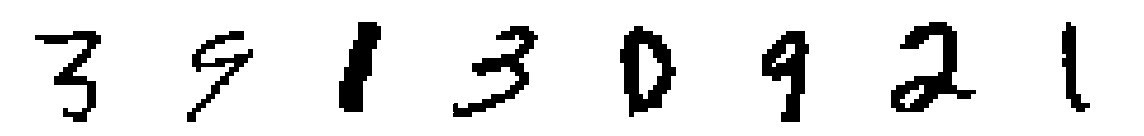

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.cm as cm
import seaborn as sns

# make sure the plots are shown in the notebook

def plot_image_grid(image_array, shape, vmin=0, vmax=1, cmap=cm.gray_r, row_titles=None):
    array = be.to_numpy_array(image_array)
    nrows, ncols = array.shape[:-1]
    f = plt.figure(figsize=(2*ncols, 2*nrows))
    grid = gs.GridSpec(nrows, ncols)
    axes = [[plt.subplot(grid[i,j]) for j in range(ncols)] for i in range(nrows)]
    for i in range(nrows):
        for j in range(ncols):
            sns.heatmap(np.reshape(array[i][j], shape),
                ax=axes[i][j], cmap=cmap, cbar=False, vmin=vmin, vmax=vmax)
            axes[i][j].set(yticks=[])
            axes[i][j].set(xticks=[])

    if row_titles is not None:
        for i in range(nrows):
            axes[i][0].set_ylabel(row_titles[i], fontsize=36)
            
    plt.tight_layout()
    plt.show(f)
    plt.close(f)
    

image_shape = (28, 28) # 28x28 = 784 pixels in every image
num_to_plot = 8 # of data points to plot

examples = data.get(mode='train') # shape (batch_size, 784)

example_plot = plot_image_grid(np.expand_dims(examples[:num_to_plot], 0), 
                               image_shape, vmin=0, vmax=1)

### Reconstructions

Having trained our models, let us see how they perform by computing some reconstructions from the validation data. 

Recall that a reconstruction ${\bf v'}$ of a given data point ${\bf x}$ is computed in two steps: (i) we fix the visible layer ${\bf v}={\bf x}$ to be the data, and use MC sampling to find the state of the hidden layer ${\bf h}$ which maximizes the probability distribution $p({\bf h}\vert{\bf v})$, (ii) fixing the same obtained state ${\bf h}$, we find the reconstruction of the visible layer ${\bf v'}$ which maximizes the probability $p({\bf v'}\vert{\bf h})$. In the case of a DBM, the forward pass continues until we reach the last of the hidden layers, and the backward pass goes in reverse. 

To compute reconstructions, we define a MC `sampler` based on the trained `model`. The stating point form the MC sampler is set using the `set_state()` method. To compute reconstructions, we need to keep the probability distribution encoded in the `model` fixed which is done with the help of the `deterministic_iteration` function method, which takes the number of weights `num_weights` in the model, and the state of the sampler `sampler.state` as required arguments. We can combine these steps in the function `compute_reconstructions`.

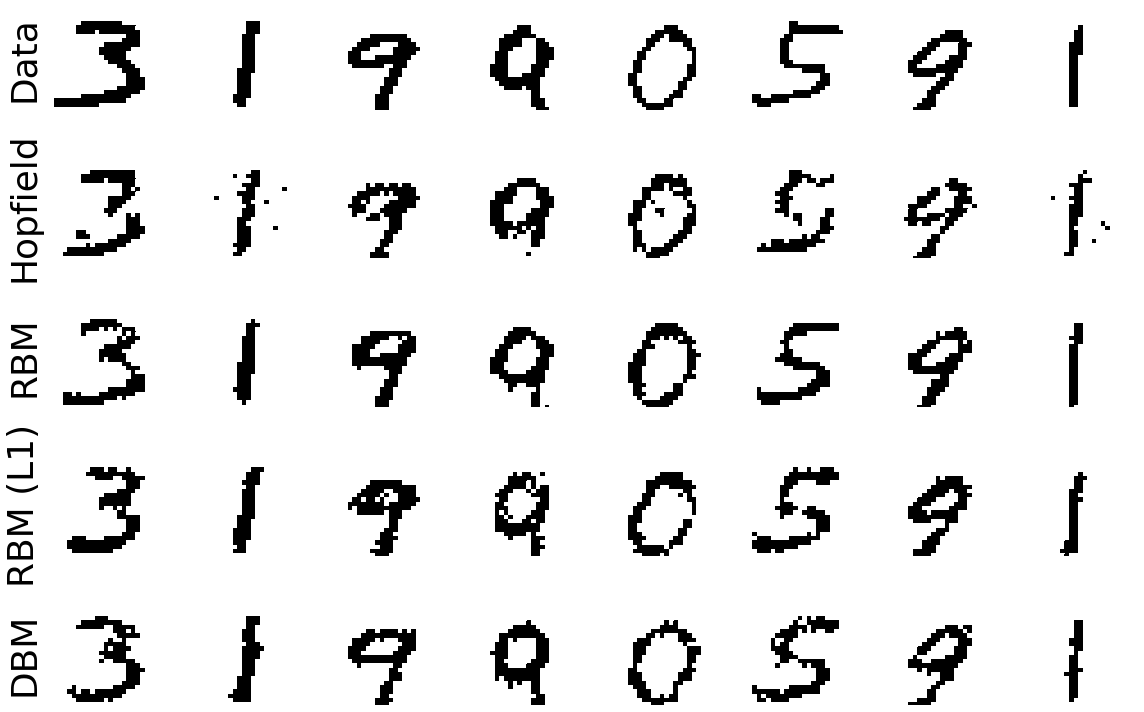

In [10]:
##### compute reconstructions
def compute_reconstructions(model, data):
    """
    Computes reconstructions of the input data.
    Input v -> h -> v' (one pass up one pass down)
    
    Args:
        model: a model
        data: a tensor of shape (num_samples, num_visible_units)

    Returns:
        tensor of shape (num_samples, num_visible_units)
    
    """
    recons = model.compute_reconstructions(data).get_visible()
    return be.to_numpy_array(recons)

examples = data.get(mode='validate') # shape (batch_size, 784)
data.reset_generator(mode='validate') # reset the generator to the beginning of the validation set

hopfield_reconstructions = compute_reconstructions(hopfield, examples[:num_to_plot])
rbm_reconstructions = compute_reconstructions(rbm, examples[:num_to_plot])
rbm_L1_reconstructions = compute_reconstructions(rbm_L1, examples[:num_to_plot])
dbm_reconstructions = compute_reconstructions(dbm, examples[:num_to_plot])

reconstruction_plot = plot_image_grid(
    np.array([examples[:num_to_plot], 
                 hopfield_reconstructions, 
                 rbm_reconstructions, 
                 rbm_L1_reconstructions,
                 dbm_reconstructions]), 
    image_shape, vmin=0, vmax=1, row_titles=["Data", "Hopfield", "RBM", "RBM (L1)", "DBM"])

### Fantasy Particles

Once we have the trained models ready, we can use MC to draw samples from the corresponding probability distributions, called "fantasy particles". To this end let us draw a `random_sample` from the validation data, and compute the `model_state`. Next, we define a MC `sampler` based on the `model`, and set its state to `model_state`. To compute the fantasy particles, we do layer-wise Gibbs sampling for a total of `n_steps` equilibration steps. The last step (controlled by the boolean `mean_field`) is a final mean-field iteration.

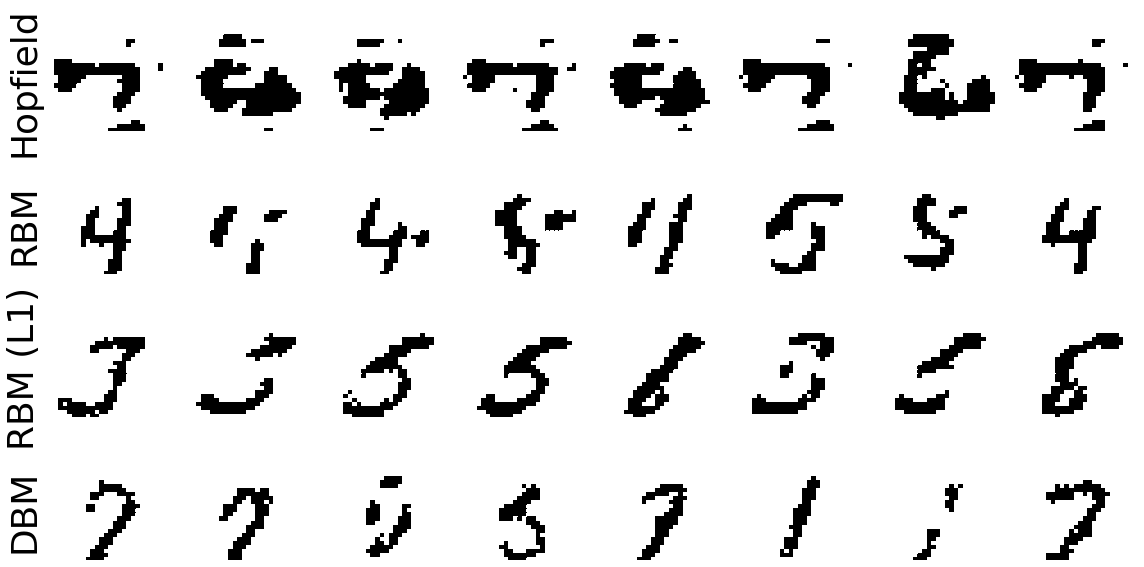

In [11]:
def compute_fantasy_particles(model,num_fantasy,num_steps,mean_field=True):
    """
    Draws samples from the model using Gibbs sampling Markov Chain Monte Carlo .
    Starts from randomly initialized points. 

    Args:
        model: a model
        data: a tensor of shape (num_samples, num_visible_units)
        num_steps (int): the number of update steps
        mean_field (bool; optional): run a final mean field step to compute probabilities

    Returns:
        tensor of shape (num_samples, num_visible_units)
    
    """
    schedule = schedules.Linear(initial=1.0, delta = 1 / (num_steps-1))
    fantasy = samplers.SequentialMC.generate_fantasy_state(model,
                                                           num_fantasy,
                                                           num_steps,
                                                           schedule=schedule,
                                                           beta_std=0.0,
                                                           beta_momentum=0.0)
    if mean_field:
        fantasy = model.mean_field_iteration(1, fantasy)
    fantasy_particles = fantasy.get_visible()        
    return be.to_numpy_array(fantasy_particles)

examples = data.get(mode='validate') # shape (batch_size, 784)
data.reset_generator(mode='validate') # reset the generator to the beginning of the validation set

hopfield_fantasy = compute_fantasy_particles(hopfield, num_to_plot, 100, mean_field=False)
rbm_fantasy = compute_fantasy_particles(rbm, num_to_plot, 100, mean_field=False)
rbm_L1_fantasy = compute_fantasy_particles(rbm_L1, num_to_plot, 100, mean_field=False)
dbm_fantasy = compute_fantasy_particles(dbm, num_to_plot, 100, mean_field=False)

fantasy_plot = plot_image_grid(
    np.array([hopfield_fantasy, 
                 rbm_fantasy, 
                 rbm_L1_fantasy,
                 dbm_fantasy]), 
    image_shape, vmin=0, vmax=1, row_titles=["Hopfield", "RBM", "RBM (L1)", "DBM"])

### De-noising Images

One can use generative models to reduce the noise in images (de-noising). Let us randomly flip a fraction, `fraction_to_flip`, of the black & white bits in the validation data, and use the models defined above to reconstruct (de-noise) the digit images:

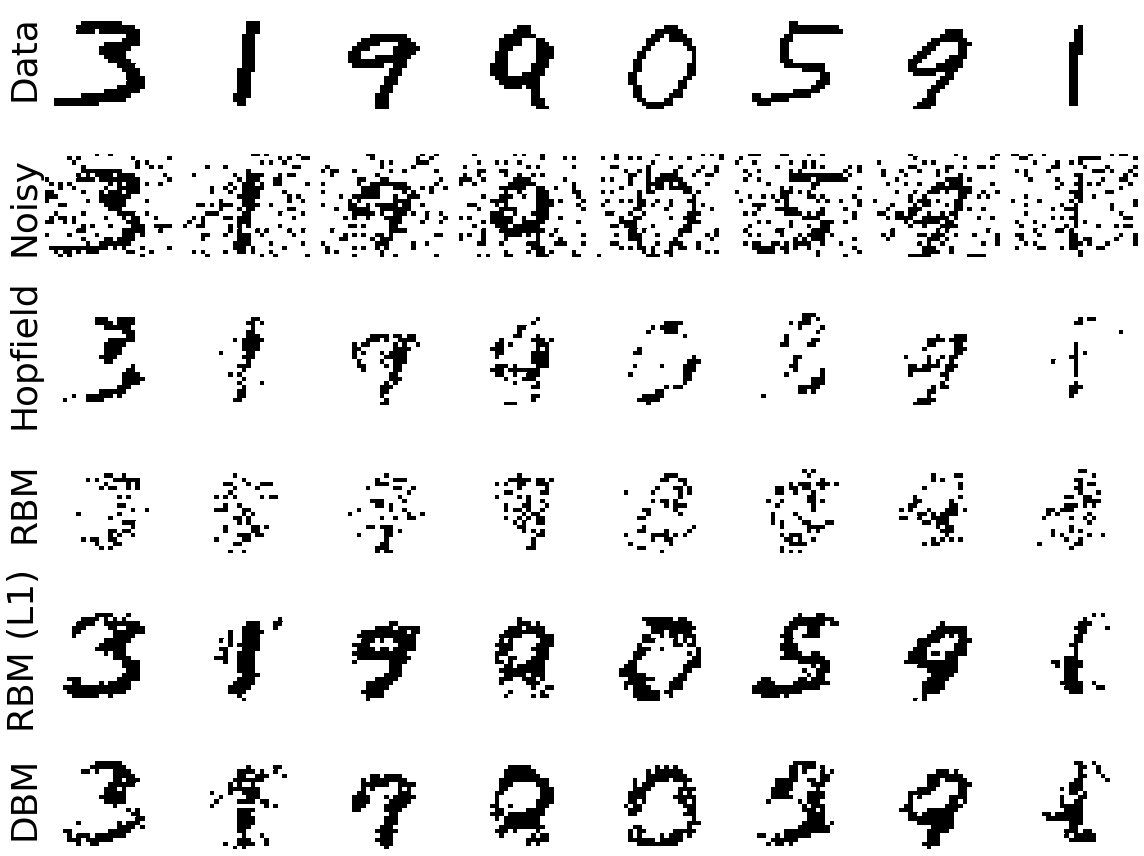

In [12]:
##### denoise MNIST images
# get validation data
examples = data.get(mode='validate') # shape (batch_size, 784)
# reset data generator to beginning of the validation set
data.reset_generator(mode='validate') 

# add some noise to the examples by randomly flipping some pixels 0 -> 1 and 1 -> 0
fraction_to_flip=0.15
# create flipping mask
flip_mask=be.rand_like(examples) < fraction_to_flip
# compute noisy data
noisy_data=(1-flip_mask) * examples + flip_mask * (1 - examples)

# define number of digits to display
num_to_display=8
# compute de-noised images
hopfield_denoised=compute_reconstructions(hopfield,noisy_data[:num_to_display])
rbm_denoised=compute_reconstructions(rbm,noisy_data[:num_to_display])
rbm_L1_denoised=compute_reconstructions(rbm_L1,noisy_data[:num_to_display])
dbm_denoised=compute_reconstructions(dbm,noisy_data[:num_to_display])

denoising_plot = plot_image_grid(
    np.array([examples[:num_to_plot], 
                 noisy_data[:num_to_plot], 
                 hopfield_denoised, 
                 rbm_denoised, 
                 rbm_L1_denoised,
                 dbm_denoised]), 
    image_shape, vmin=0, vmax=1, row_titles=["Data", "Noisy", "Hopfield", "RBM", "RBM (L1)", "DBM"])

### Weight Visualization

Let us open up the black box of our generative models now. Below, we show the features learned by the weights of the different models.

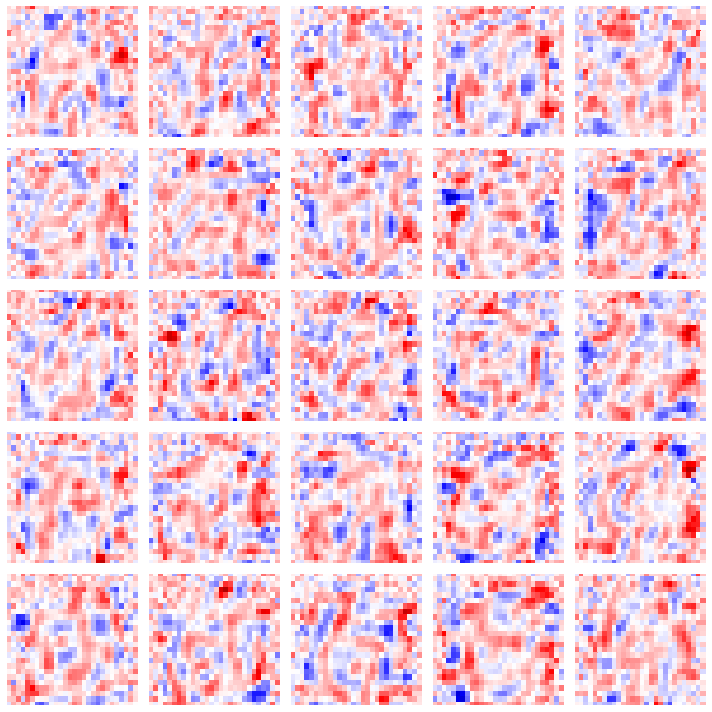

In [13]:
# plot the weights of the hopfield model
hopfield_weights = plot_image_grid(
    be.reshape(hopfield.connections[0].weights.W(trans=True)[:25], (5,5,784)), 
    image_shape, 
    vmin=be.tmin(hopfield.connections[0].weights.W()), 
    vmax=be.tmax(hopfield.connections[0].weights.W()),
    cmap=cm.seismic)

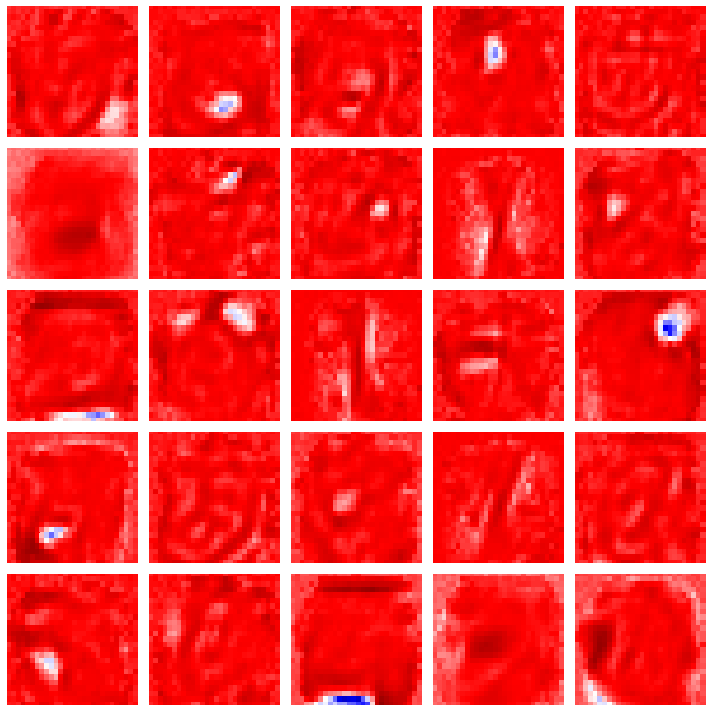

In [14]:
# plot the weights of the RBM
rbm_weights = plot_image_grid(
    be.reshape(rbm.connections[0].weights.W(trans=True)[:25], (5,5,784)), 
    image_shape, 
    vmin=be.tmin(rbm.connections[0].weights.W()), 
    vmax=be.tmax(rbm.connections[0].weights.W()),
    cmap=cm.seismic)

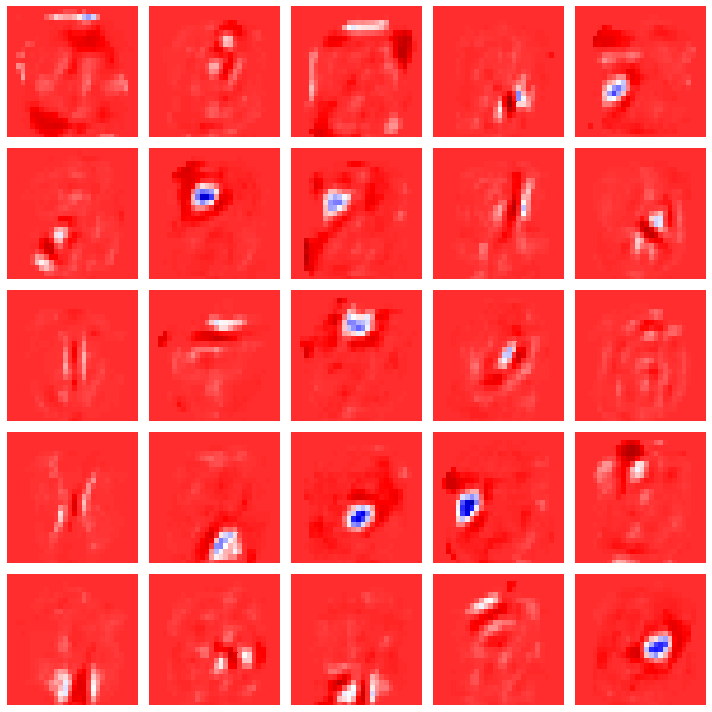

In [15]:
# plot the weights of the L1 regularized RBM
rbmL1_weights = plot_image_grid(
    be.reshape(rbm_L1.connections[0].weights.W(trans=True)[:25], (5,5,784)), 
    image_shape, 
    vmin=be.tmin(rbm_L1.connections[0].weights.W()), 
    vmax=be.tmax(rbm_L1.connections[0].weights.W()),
    cmap=cm.seismic)

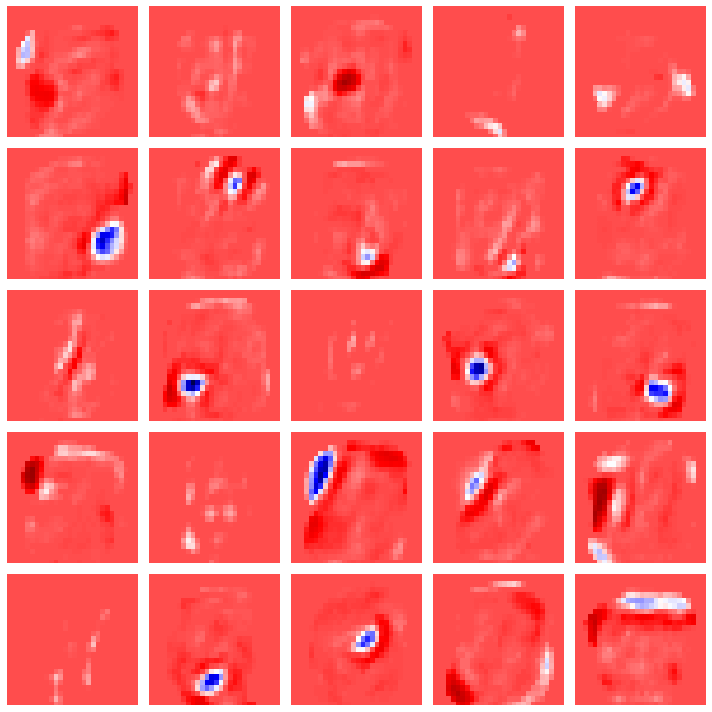

In [16]:
# plot the weights of the first layer of the dbm
dbm_weights = plot_image_grid(
    be.reshape(dbm.connections[0].weights.W(trans=True)[:25], (5,5,784)), 
    image_shape, 
    vmin=be.tmin(dbm.connections[0].weights.W()), 
    vmax=be.tmax(dbm.connections[0].weights.W()),
    cmap=cm.seismic)

In [17]:
data.close() # close the HDF5 store with the MNIST dataset

## Exercises

* Try increasing/decreasing the number of hidden units and study systematically how the performance of the different models changes.
* Look up Paysage's documentation and study the performance for various SGD optimizers.

* Try increasing/decreasing the number of hidden units and study systematically how the performance of the different models changes.

Before training:
-ReconstructionError: 1.224457
-EnergyCoefficient: 0.108183
-HeatCapacity: 1.246062
-WeightSparsity: 0.331073
-WeightSquare: 1.912796
-KLDivergence: 0.165948
-ReverseKLDivergence: -0.043305

End of epoch 1: 
Time elapsed 3.084s
-ReconstructionError: 1.008574
-EnergyCoefficient: 0.251767
-HeatCapacity: 8.639853
-WeightSparsity: 0.328719
-WeightSquare: 8.904221
-KLDivergence: 0.103200
-ReverseKLDivergence: 0.093178

End of epoch 2: 
Time elapsed 3.054s
-ReconstructionError: 0.986182
-EnergyCoefficient: 0.470723
-HeatCapacity: 102.417510
-WeightSparsity: 0.308897
-WeightSquare: 10.732841
-KLDivergence: 0.246543
-ReverseKLDivergence: 0.434577

End of epoch 3: 
Time elapsed 3.029s
-ReconstructionError: 0.954538
-EnergyCoefficient: 0.205860
-HeatCapacity: 59.481424
-WeightSparsity: 0.319767
-WeightSquare: 13.446126
-KLDivergence: 0.053434
-ReverseKLDivergence: 0.077334

End of epoch 4: 
Time elapsed 3.33s
-ReconstructionError: 0.943687
-EnergyCoefficient: 0.233811
-HeatCapac

End of epoch 4: 
Time elapsed 12.618s
-ReconstructionError: 0.772132
-EnergyCoefficient: 0.273788
-HeatCapacity: 51.474226
-WeightSparsity: 0.271339
-WeightSquare: 3.438958
-KLDivergence: 0.079848
-ReverseKLDivergence: 0.243992

End of epoch 5: 
Time elapsed 10.049s
-ReconstructionError: 0.760722
-EnergyCoefficient: 0.343192
-HeatCapacity: 7.926253
-WeightSparsity: 0.275249
-WeightSquare: 3.765331
-KLDivergence: 0.072622
-ReverseKLDivergence: 0.317963

End of epoch 6: 
Time elapsed 10.604s
-ReconstructionError: 0.730181
-EnergyCoefficient: 0.390277
-HeatCapacity: 15.362848
-WeightSparsity: 0.274460
-WeightSquare: 4.282722
-KLDivergence: 0.109822
-ReverseKLDivergence: 0.398200

End of epoch 7: 
Time elapsed 12.327s
-ReconstructionError: 0.742636
-EnergyCoefficient: 0.478540
-HeatCapacity: 258.055553
-WeightSparsity: 0.277933
-WeightSquare: 4.675146
-KLDivergence: 0.197957
-ReverseKLDivergence: 0.515266

End of epoch 8: 
Time elapsed 11.16s
-ReconstructionError: 0.729623
-EnergyCoefficie

-ReconstructionError: 0.755157
-EnergyCoefficient: 0.429208
-HeatCapacity: 14.048456
-WeightSparsity: 0.293350
-WeightSquare: 2.095030
-KLDivergence: 0.090882
-ReverseKLDivergence: 0.405924

End of epoch 8: 
Time elapsed 9.287s
-ReconstructionError: 0.736882
-EnergyCoefficient: 0.306006
-HeatCapacity: 14.699428
-WeightSparsity: 0.291174
-WeightSquare: 2.090807
-KLDivergence: 0.034175
-ReverseKLDivergence: 0.225914

End of epoch 9: 
Time elapsed 9.609s
-ReconstructionError: 0.727130
-EnergyCoefficient: 0.419377
-HeatCapacity: 2.358224
-WeightSparsity: 0.281984
-WeightSquare: 2.212560
-KLDivergence: 0.046765
-ReverseKLDivergence: 0.334784

End of epoch 10: 
Time elapsed 9.546s
-ReconstructionError: 0.728293
-EnergyCoefficient: 0.371849
-HeatCapacity: 10.854713
-WeightSparsity: 0.272271
-WeightSquare: 2.354371
-KLDivergence: 0.085628
-ReverseKLDivergence: 0.343465



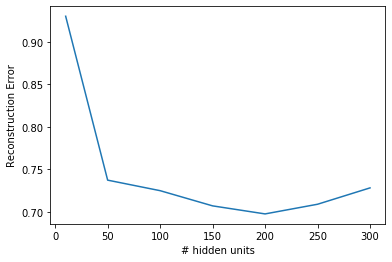

In [41]:
##### create hopfield model
# hidden units
num_hidden_array = [10, 50, 100, 150, 200, 250, 300]
res_hidden_array = []

for num_hidden_units in num_hidden_array:
    
    print("")
    # set up the model
    vis_layer = BernoulliLayer(data.ncols)
    hid_layer = GaussianLayer(num_hidden_units)
    hopfield = BoltzmannMachine([vis_layer, hid_layer])

    # set mean and standard deviation of hidden layer to to 0 and 1, respectively
    hopfield.layers[1].set_fixed_params(['loc', 'log_var'])

    num_epochs=10 # training epochs
    monte_carlo_steps=1 # number of MC sampling steps
    
    res_hidden = train_model(hopfield,num_epochs,monte_carlo_steps)
    res_hidden_array.append(res_hidden)
    
import matplotlib.pyplot as plt
plt.plot(num_hidden_array, res_hidden_array)
plt.ylabel('Reconstruction Error')
plt.xlabel('# hidden units')
plt.show()

Before training:
-ReconstructionError: 1.228667
-EnergyCoefficient: 0.109177
-HeatCapacity: 1.216178
-WeightSparsity: 0.324518
-WeightSquare: 1.922448
-KLDivergence: 0.165459
-ReverseKLDivergence: -0.042590

End of epoch 1: 
Time elapsed 2.743s
-ReconstructionError: 1.086994
-EnergyCoefficient: 0.179817
-HeatCapacity: 1.817267
-WeightSparsity: 0.346892
-WeightSquare: 284.289185
-KLDivergence: 0.104686
-ReverseKLDivergence: 0.011794

End of epoch 2: 
Time elapsed 3.198s
-ReconstructionError: 1.065342
-EnergyCoefficient: 0.143031
-HeatCapacity: 2.486584
-WeightSparsity: 0.368237
-WeightSquare: 552.851611
-KLDivergence: 0.079605
-ReverseKLDivergence: 0.004359

End of epoch 3: 
Time elapsed 2.678s
-ReconstructionError: 1.055372
-EnergyCoefficient: 0.183944
-HeatCapacity: 3.444233
-WeightSparsity: 0.375389
-WeightSquare: 813.957617
-KLDivergence: 0.087588
-ReverseKLDivergence: 0.029787

End of epoch 4: 
Time elapsed 2.818s
-ReconstructionError: 1.048467
-EnergyCoefficient: 0.189528
-HeatCap

End of epoch 1: 
Time elapsed 6.745s
-ReconstructionError: 0.869941
-EnergyCoefficient: 0.385841
-HeatCapacity: 0.853463
-WeightSparsity: 0.237555
-WeightSquare: 22.952961
-KLDivergence: 0.110754
-ReverseKLDivergence: 0.312665

End of epoch 2: 
Time elapsed 8.313s
-ReconstructionError: 0.790977
-EnergyCoefficient: 0.334853
-HeatCapacity: 1.381649
-WeightSparsity: 0.229686
-WeightSquare: 37.870745
-KLDivergence: 0.110189
-ReverseKLDivergence: 0.247348

End of epoch 3: 
Time elapsed 9.292s
-ReconstructionError: 0.754347
-EnergyCoefficient: 0.334216
-HeatCapacity: 2.016848
-WeightSparsity: 0.224692
-WeightSquare: 56.131328
-KLDivergence: 0.083108
-ReverseKLDivergence: 0.333380

End of epoch 4: 
Time elapsed 8.588s
-ReconstructionError: 0.722114
-EnergyCoefficient: 0.316191
-HeatCapacity: 0.741722
-WeightSparsity: 0.219126
-WeightSquare: 72.624993
-KLDivergence: 0.112084
-ReverseKLDivergence: 0.216124

End of epoch 5: 
Time elapsed 8.558s
-ReconstructionError: 0.703695
-EnergyCoefficient: 

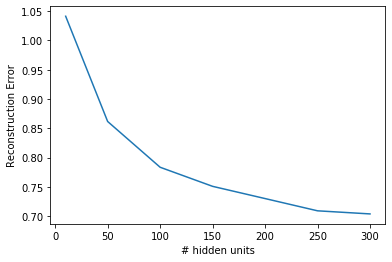

In [43]:
##### Bernoulli RBM
num_hidden_array = [10, 50, 100, 150, 200, 250, 300]
res_hidden_array = []

for num_hidden_units in num_hidden_array:

    # set up the model
    vis_layer = BernoulliLayer(data.ncols)
    hid_layer = BernoulliLayer(num_hidden_units)
    rbm = BoltzmannMachine([vis_layer, hid_layer])

    num_epochs=5 # training epochs
    monte_carlo_steps=1 # number of MC sampling steps
    
    res_hidden = train_model(rbm,num_epochs,monte_carlo_steps)
    res_hidden_array.append(res_hidden)
    
import matplotlib.pyplot as plt
plt.plot(num_hidden_array, res_hidden_array)
plt.ylabel('Reconstruction Error')
plt.xlabel('# hidden units')
plt.show()

Before training:
-ReconstructionError: 1.227291
-EnergyCoefficient: 0.108739
-HeatCapacity: 1.226605
-WeightSparsity: 0.324779
-WeightSquare: 1.991203
-KLDivergence: 0.164180
-ReverseKLDivergence: -0.043903

End of epoch 1: 
Time elapsed 3.586s
-ReconstructionError: 1.084019
-EnergyCoefficient: 0.131990
-HeatCapacity: 1.573813
-WeightSparsity: 0.244521
-WeightSquare: 164.976941
-KLDivergence: 0.100470
-ReverseKLDivergence: -0.003256

End of epoch 2: 
Time elapsed 3.561s
-ReconstructionError: 1.062492
-EnergyCoefficient: 0.180402
-HeatCapacity: 1.702450
-WeightSparsity: 0.259416
-WeightSquare: 319.860010
-KLDivergence: 0.098722
-ReverseKLDivergence: 0.017198

End of epoch 3: 
Time elapsed 3.515s
-ReconstructionError: 1.047043
-EnergyCoefficient: 0.126012
-HeatCapacity: 2.921231
-WeightSparsity: 0.258627
-WeightSquare: 464.030859
-KLDivergence: 0.070281
-ReverseKLDivergence: 0.004372

End of epoch 4: 
Time elapsed 3.408s
-ReconstructionError: 1.042548
-EnergyCoefficient: 0.181653
-HeatCa

End of epoch 1: 
Time elapsed 9.554s
-ReconstructionError: 0.891122
-EnergyCoefficient: 0.315595
-HeatCapacity: 0.347436
-WeightSparsity: 0.116382
-WeightSquare: 11.756987
-KLDivergence: 0.156008
-ReverseKLDivergence: 0.145387

End of epoch 2: 
Time elapsed 10.109s
-ReconstructionError: 0.808899
-EnergyCoefficient: 0.299833
-HeatCapacity: 0.766292
-WeightSparsity: 0.106106
-WeightSquare: 19.805894
-KLDivergence: 0.103306
-ReverseKLDivergence: 0.201823

End of epoch 3: 
Time elapsed 10.486s
-ReconstructionError: 0.740944
-EnergyCoefficient: 0.292119
-HeatCapacity: 0.746692
-WeightSparsity: 0.095005
-WeightSquare: 27.158019
-KLDivergence: 0.066802
-ReverseKLDivergence: 0.232301

End of epoch 4: 
Time elapsed 9.847s
-ReconstructionError: 0.744025
-EnergyCoefficient: 0.368206
-HeatCapacity: 1.530824
-WeightSparsity: 0.087006
-WeightSquare: 34.895993
-KLDivergence: 0.173868
-ReverseKLDivergence: 0.271335

End of epoch 5: 
Time elapsed 10.044s
-ReconstructionError: 0.710154
-EnergyCoefficien

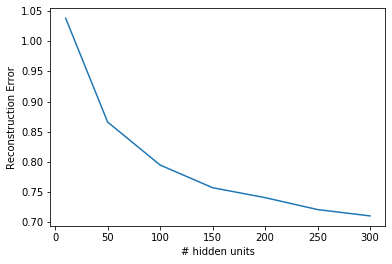

In [44]:
##### Bernoulli RBM with L1 regularizer
num_hidden_array = [10, 50, 100, 150, 200, 250, 300]
res_hidden_array = []

for num_hidden_units in num_hidden_array:

    ##### Bernoulli RBM with L1 regularizer
    vis_layer = BernoulliLayer(data.ncols)
    hid_layer = BernoulliLayer(num_hidden_units)
    rbm_L1 = BoltzmannMachine([vis_layer, hid_layer])

    rbm_L1.connections[0].weights.add_penalty({'matrix': pen.l1_penalty(1e-3)})

    num_epochs=5 # training epochs
    monte_carlo_steps=1 # number of MC sampling steps
    
    res_hidden = train_model(rbm_L1,num_epochs,monte_carlo_steps)
    res_hidden_array.append(res_hidden)
    
import matplotlib.pyplot as plt
plt.plot(num_hidden_array, res_hidden_array)
plt.ylabel('Reconstruction Error')
plt.xlabel('# hidden units')
plt.show()

* Look up Paysage's documentation and study the performance for various SGD optimizers.

In [52]:
# set up an optimizer method (RMSProp in this case)
def RMSProp_optimizer(initial,coefficient):
	# define learning rate attenuation schedule
	learning_rate=schedules.PowerLawDecay(initial=initial,coefficient=coefficient)
	# return optimizer object
	return optimizers.RMSProp(stepsize=learning_rate)

# set up an optimizer method (Gradient in this case)
def Gradient_optimizer(initial,coefficient):
	# define learning rate attenuation schedule
	learning_rate=schedules.PowerLawDecay(initial=initial,coefficient=coefficient)
	# return optimizer object
	return optimizers.Gradient(stepsize=learning_rate)

# set up an optimizer method (Momentum in this case)
def Momentum_optimizer(initial,coefficient):
	# define learning rate attenuation schedule
	learning_rate=schedules.PowerLawDecay(initial=initial,coefficient=coefficient)
	# return optimizer object
	return optimizers.Momentum(stepsize=learning_rate)

def train_model(model,num_epochs,monte_carlo_steps, opt_function):
        # make a simple guess for the initial parameters of the model
        model.initialize(data,method='glorot_normal')
        # set optimizer
        opt=opt_function(1E-2,1.0)
        trainer = fit.SGD(model, data)
        trainer.train(opt, num_epochs, method=fit.pcd, mcsteps=monte_carlo_steps)

In [55]:
num_hidden_units=200 

# set up the model
vis_layer = BernoulliLayer(data.ncols)
hid_layer = GaussianLayer(num_hidden_units)
hopfield = BoltzmannMachine([vis_layer, hid_layer])

# set mean and standard deviation of hidden layer to to 0 and 1, respectively
hopfield.layers[1].set_fixed_params(['loc', 'log_var'])

# train hopfield model
train_model(hopfield,5,1,Momentum_optimizer)

Before training:
-ReconstructionError: 1.203351
-EnergyCoefficient: 0.131332
-HeatCapacity: 0.394455
-WeightSparsity: 0.334025
-WeightSquare: 1.595385
-KLDivergence: 0.189429
-ReverseKLDivergence: -0.039428

End of epoch 1: 
Time elapsed 6.867s
-ReconstructionError: 0.932807
-EnergyCoefficient: 0.386884
-HeatCapacity: 51.199274
-WeightSparsity: 0.311194
-WeightSquare: 1.616296
-KLDivergence: 0.191360
-ReverseKLDivergence: 0.291585

End of epoch 2: 
Time elapsed 7.537s
-ReconstructionError: 0.937080
-EnergyCoefficient: 0.362871
-HeatCapacity: 3.538727
-WeightSparsity: 0.305838
-WeightSquare: 1.492039
-KLDivergence: 0.175224
-ReverseKLDivergence: 0.234081

End of epoch 3: 
Time elapsed 7.685s
-ReconstructionError: 0.909194
-EnergyCoefficient: 0.280477
-HeatCapacity: 10.113704
-WeightSparsity: 0.293693
-WeightSquare: 1.469777
-KLDivergence: 0.131428
-ReverseKLDivergence: 0.166552

End of epoch 4: 
Time elapsed 7.198s
-ReconstructionError: 0.882439
-EnergyCoefficient: 0.353138
-HeatCapacit